### Project title:

### Introduction:

### Preliminary exploratory data analysis:

In [51]:
library(tidyverse)
library(readxl)
library(dplyr)
options(repr.matrix.max.rows = 6)

In [2]:
# reding the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data

# select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

training_data

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [3]:
# summarize the training data, counting how many occurences of each class 
num_of_class <- training_data %>%
    count(UNS)

num_of_class

UNS,n
<fct>,<int>
very_low,24
High,63
Low,83
Middle,88


In [5]:
#the means of the predictor variables you plan to use in your analysis
predictors_mean <- training_data %>%
                  summarize (mean_STG = mean(STG, na.rm = TRUE),
                             mean_PEG = mean(PEG, na.rm = TRUE))
predictors_mean

mean_STG,mean_PEG
<dbl>,<dbl>
0.3711473,0.4585388


In [8]:
#how many rows have missing data
missing_data <- training_data %>% 
        filter(is.na(STG), is.na(PEG), is.na(SCG), is.na(STR), is.na(LPR), is.na(UNS))
missing_data_count <- nrow(missing_data)
missing_data_count

[1] 0

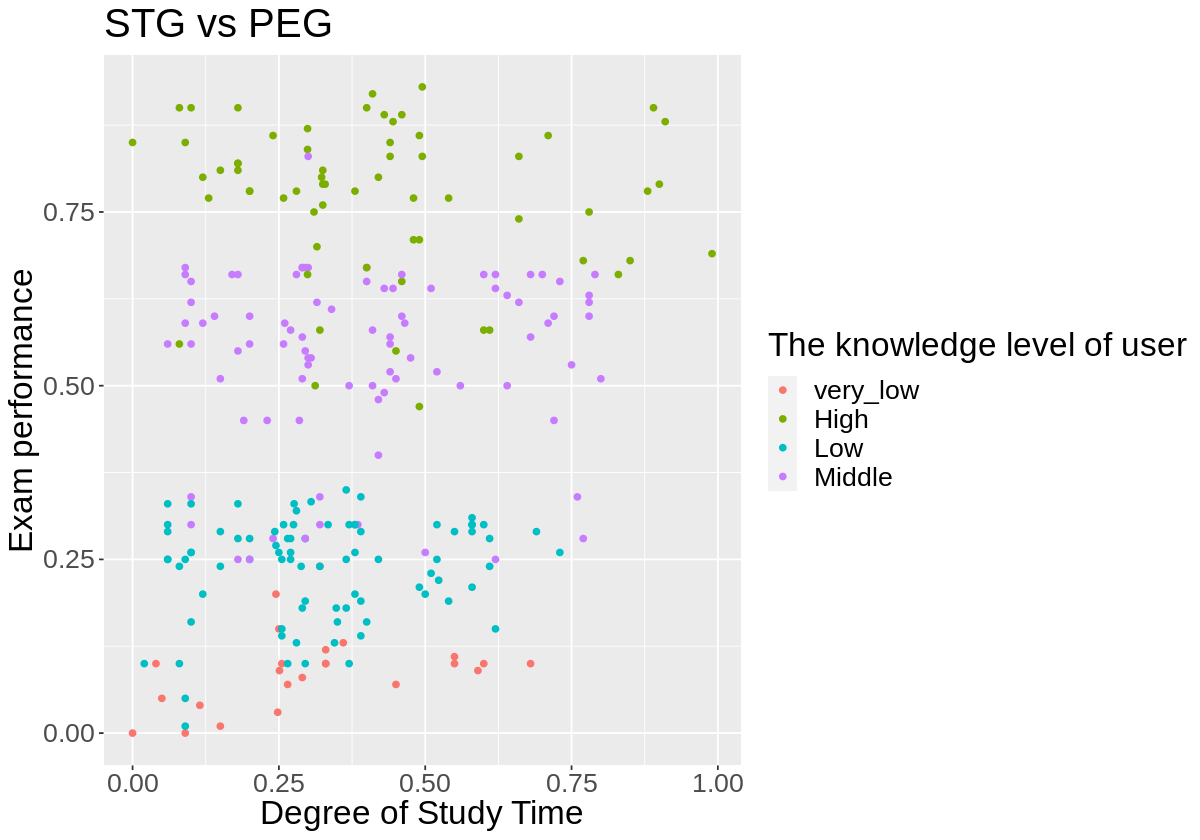

In [22]:
# plot STG vs PEG and coloring the class of UNS
# STG => The degree of study time for goal object materails
# PEG => The exam performance of user for goal objects
options(repr.plot.width = 10, repr.plot.height = 7) 
plot <- training_data %>%
    ggplot(aes(x = STG, y = PEG, color = UNS)) +
    geom_point() +
    labs(x = "Degree of Study Time", y="Exam performance", color= "The knowledge level of user")+
    ggtitle('STG vs PEG')+
    theme(text = element_text(size=20))

plot

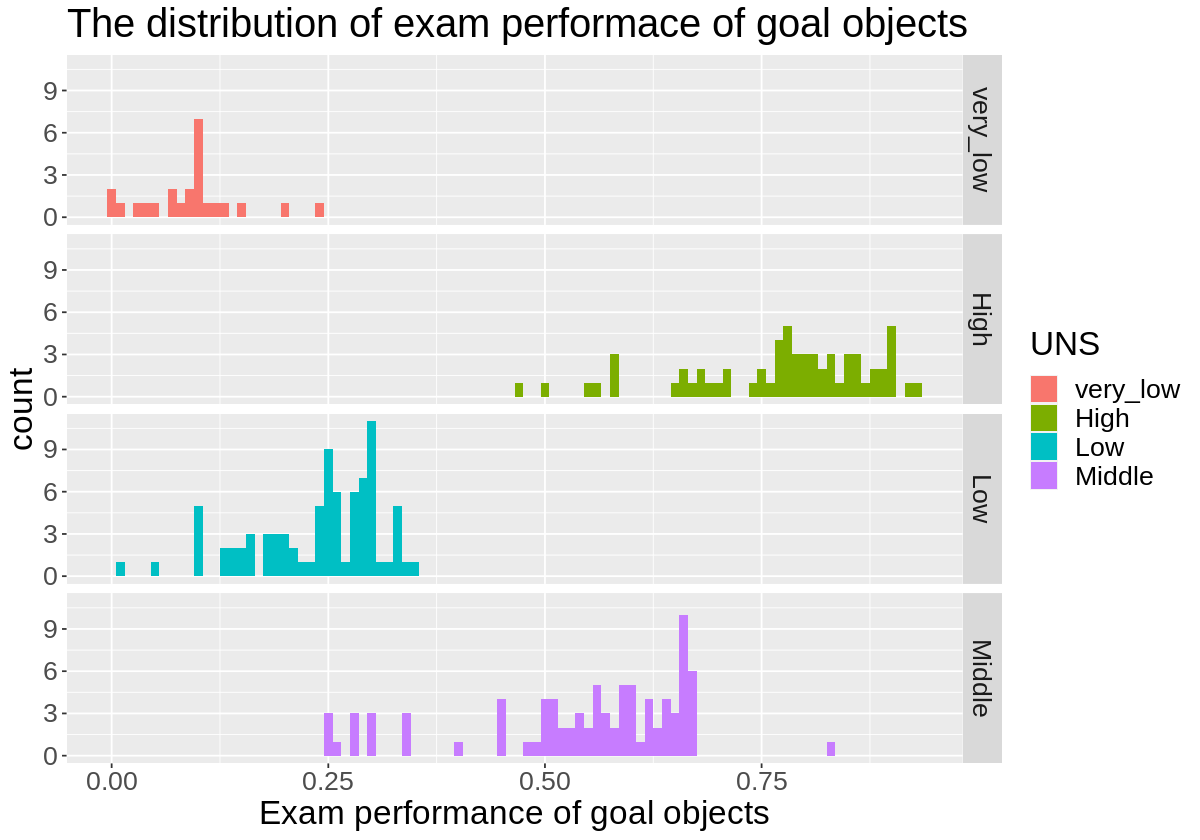

In [53]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The distribution of exam performace of goal objects
options(repr.plot.width = 10, repr.plot.height = 7) 
distr_PEG <- training_data %>%
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of goal objects", color= "The knowledge level of user")+
    ggtitle("The distribution of exam performace of goal objects")+
    theme(text = element_text(size=20))+
    facet_grid(rows = vars(UNS))

distr_PEG

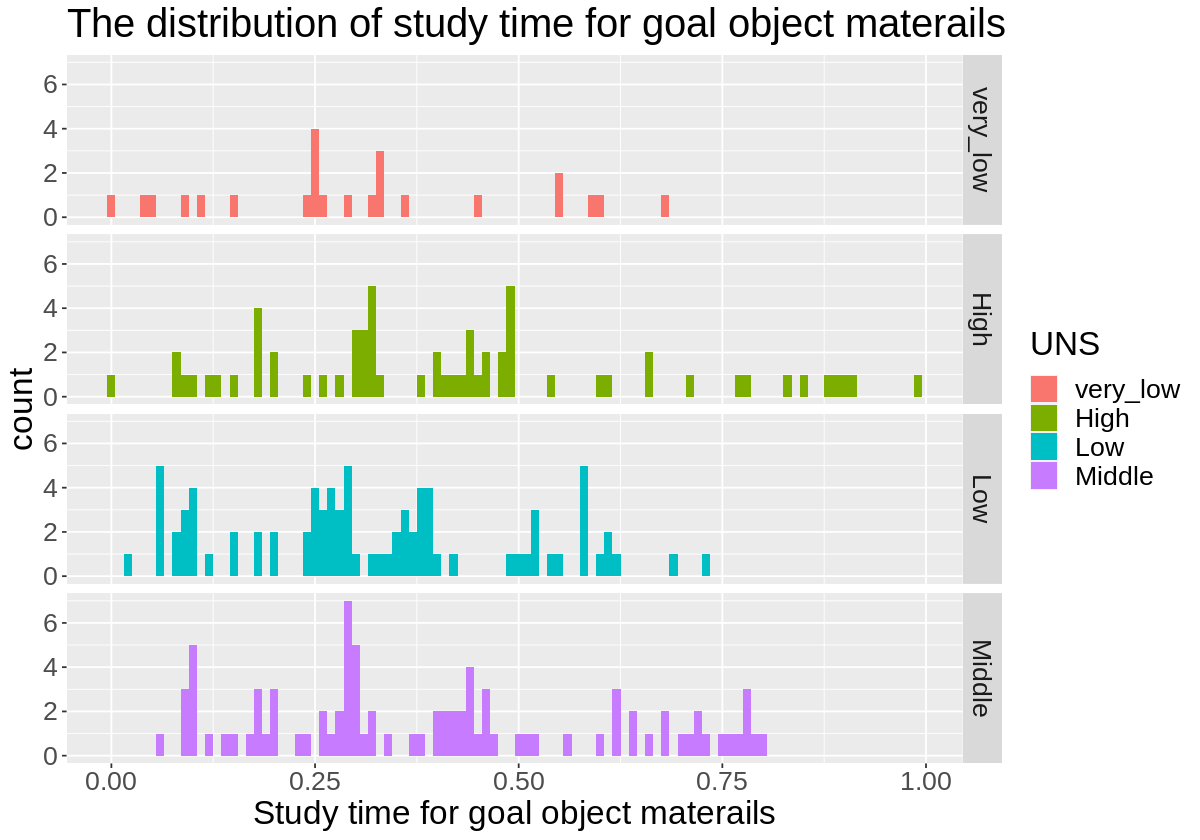

In [54]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The distribution of the degree of study time for goal object materails (STG)
options(repr.plot.width = 10, repr.plot.height = 7) 
distr_STG <- training_data %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Study time for goal object materails", color= "The knowledge level of user")+
    ggtitle("The distribution of study time for goal object materails")+
    theme(text = element_text(size= 20))+
    facet_grid(rows = vars(UNS))

distr_STG


### Methods:

### Expected outcomes and significance: